<a href="https://colab.research.google.com/github/Quintaneishon/ImageAnalysis/blob/master/IA_P3_2017631261.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://drive.google.com/uc?id=1fo5VGc3fDGcrg-9tudhG4BRuXlN7bXgS" alt="header" style="height:200px;">

# Image Analysis

**Quintana Ruiz Ajitzi Ricardo**

**Boleta: 2017631261**

**Grupo: 3CV6**

03 - Non-linear filters and neighbourhoods


In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
%load_ext Cython
import requests
from io import BytesIO

<h3>Some Helpful Functions</h3>

<h2>Salt and Pepper Noise</h2>
Salt and pepper noise is a form of noise sometimes seen on images. It is also known as impulse noise. This noise can be caused by sharp and sudden disturbances in the image signal. It presents itself as sparsely occurring white and black pixels.

In [0]:
#Displays an array as an image
def im_show(pic,ip):
    height=pic.shape[0]
    width=pic.shape[1]
    
    print(type(pic))
    channels=1
    if pic.ndim>2:
        channels=3
    #ip="nearest"
    plt.figure(figsize=(10,int(10*float(height)/float(width)) ))
    if channels==1:
        plt.imshow(pic,cmap='gray',interpolation=ip,aspect="auto")
    else:
        plt.imshow(pic,interpolation=ip,aspect="auto")

def im_load(file):
    pic=Image.open(file) #Open the image
    print("Image type:"+str(type(pic))) #Displays the type of image (JPEG, BMP, PNG, GIF, etc)
    pic_arr = np.asarray(pic) #converts the image to an Numpy Array
    print("Dimentions"+str(pic_arr.shape)) #(height,width,#of channels)
    pic_channels=1
    if pic_arr.ndim>2:
        pic_channels=3
    print("Channels:"+str(pic_channels))
    #im_show(pic_arr)
    return pic_arr

def grayscale(pic):
    height=pic.shape[0]
    width=pic.shape[1]
    
    channels=1
    if pic.ndim==3:
        channels=pic.shape[2]
    
    if channels==1:
        return pic

    factor=np.array([0.24,0.65,0.11])
    if channels==4:
        factor=np.array([0.24,0.65,0.11,1])

    pic2=np.dot(pic.astype(dtype=np.float),factor)

    return pic2.astype(dtype=np.uint8)

def noise(img, salt, pepper):
    height=img.shape[0]
    width=img.shape[1]  
    img_r=np.asarray(img.copy(),order="C")
    
    hw=height*width
    
    if salt>0 and salt<=1:
        npixels=int(float(hw)*salt)
        for i in range(npixels):
            x = np.random.randint(0,width,1)
            y = np.random.randint(0,height,1)
            img_r[y[0],x[0]]=255
            
        
    if pepper>0 and pepper<=1:
        npixels=int(float(hw)*pepper)
        for i in range(npixels):
            x = np.random.randint(0,width,1)
            y = np.random.randint(0,height,1)
            img_r[y[0],x[0]]=0
    
    return img_r

Image type:<class 'PIL.PngImagePlugin.PngImageFile'>
Dimentions(512, 512, 3)
Channels:3
CPU times: user 7.58 ms, sys: 2.99 ms, total: 10.6 ms
Wall time: 10.7 ms
(512, 512)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
CPU times: user 293 ms, sys: 0 ns, total: 293 ms
Wall time: 297 ms
<class 'numpy.ndarray'>


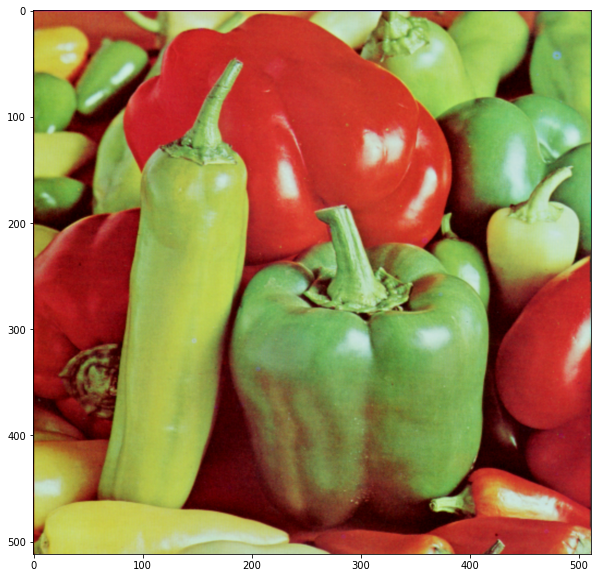

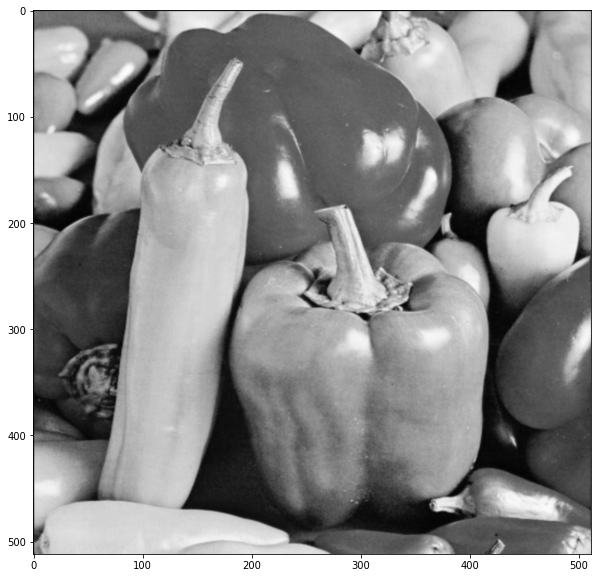

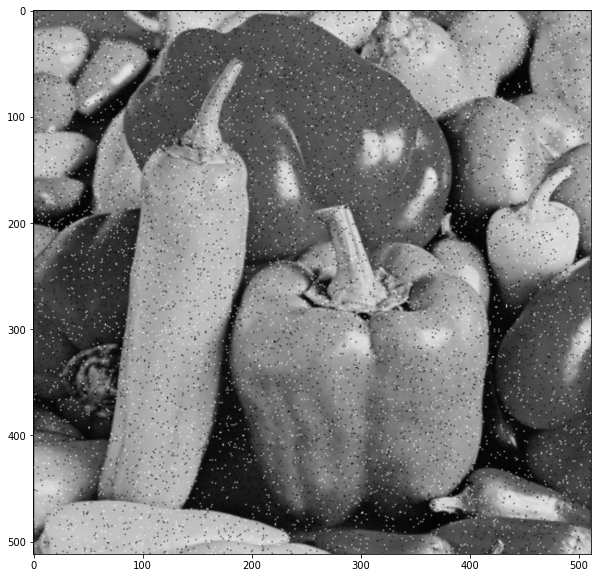

In [0]:
url="https://drive.google.com/uc?id=1HCVHyrLztG3gCqn5uITCMEcJ0J-t6UDY" #peppers.png
#url = "https://drive.google.com/uc?id=19zyR22cAa68mnCUWKiiz8onN3J0tHTA9" #concert
response = requests.get(url)
pic1=im_load(BytesIO(response.content))
%time pic1_gray=grayscale(pic1)
print(pic1_gray.shape)
im_show(pic1,"bicubic")
im_show(pic1_gray,"bicubic")
%time pic1_gray_noised=noise(pic1_gray,0.02,0.02)
im_show(pic1_gray_noised,"bicubic")

<h2>Sliding Neighborhood Operations</h2>

A sliding neighborhood operation is an operation that is performed a pixel at a time, with the value of any given pixel in the output image being determined by the application of an algorithm to the values of the corresponding input pixel's neighborhood. A pixel's neighborhood is some set of pixels, defined by their locations relative to that pixel, which is called the center pixel. The neighborhood is a rectangular block, and as you move from one element to the next in an image matrix, the neighborhood block slides in the same direction.

In this case de median filtar sort the values in the mask and take the median value.

The max filter take the max value of the values in the mask

The min filter take the min value of the values in the mask

The media filter take the average of the values in the mask

In [0]:
%%cython -a
import numpy as np
cimport cython
@cython.boundscheck(False) 
@cython.wraparound(False)

def median_filter (const unsigned char[:,:] img, const double [:,:] mask, const int mask_oX, const int mask_oY):
  cdef int height=img.shape[0]
  cdef int width=img.shape[1]
  cdef int mask_height=mask.shape[0]
  cdef int mask_width=mask.shape[1]
  cdef int x,y,mask_i,mask_j,img_i,img_j
  cdef double res
  cdef img_r=np.zeros((height,width),dtype=np.uint8)
  cdef img_t=np.zeros((height+mask_height-1,width+mask_width-1),dtype=np.int16)
  
  cdef int mask_size=0
  for mask_j in range (mask_height):  #FOR EVERY MASK ROW
    for mask_i in range (mask_width): #FOR EVERY MASK COLUMN
      if mask[mask_j,mask_i]>0:
        mask_size+=1
  cdef t_arr=np.zeros(mask_size)

  img_t[mask_oY:height+mask_oY,mask_oX:width+mask_oX] = img.copy()

  for y in range (height):  #FOR EVERY ROW
    for x in range (width): #FOR EVERY COLUMN
      
      res=0
      i=0
      img_j=y

      for mask_j in range (mask_height):  #FOR EVERY MASK ROW
        img_i=x
        for mask_i in range(mask_width):  #FOR EVERY MASK COLUMN
          if mask[mask_j,mask_i]>0:
            t_arr[i]=img_t[img_j,img_i]
            i+=1
          img_i+=1

        img_j+=1
      
      res=np.median(t_arr)
      img_r[y,x]=int(res)

  return img_r

def max_filter (const unsigned char[:,:] img, const double [:,:] mask, const int mask_oX, const int mask_oY):
  cdef int height=img.shape[0]
  cdef int width=img.shape[1]
  cdef int mask_height=mask.shape[0]
  cdef int mask_width=mask.shape[1]
  cdef int x,y,mask_i,mask_j,img_i,img_j
  cdef double res
  cdef img_r=np.zeros((height,width),dtype=np.uint8)
  cdef img_t=np.zeros((height+mask_height-1,width+mask_width-1),dtype=np.int16)
  
  cdef int mask_size=0
  for mask_j in range (mask_height):  #FOR EVERY MASK ROW
    for mask_i in range (mask_width): #FOR EVERY MASK COLUMN
      if mask[mask_j,mask_i]>0:
        mask_size+=1
  cdef t_arr=np.zeros(mask_size)

  img_t[mask_oY:height+mask_oY,mask_oX:width+mask_oX] = img.copy()

  for y in range (height):  #FOR EVERY ROW
    for x in range (width): #FOR EVERY COLUMN
      
      res=0
      i=0
      img_j=y

      for mask_j in range (mask_height):  #FOR EVERY MASK ROW
        img_i=x
        for mask_i in range(mask_width):  #FOR EVERY MASK COLUMN
          if mask[mask_j,mask_i]>0:
            t_arr[i]=img_t[img_j,img_i]
            i+=1
          img_i+=1

        img_j+=1
      
      res=np.max(t_arr)
      img_r[y,x]=int(res)

  return img_r

def min_filter (const unsigned char[:,:] img, const double [:,:] mask, const int mask_oX, const int mask_oY):
  cdef int height=img.shape[0]
  cdef int width=img.shape[1]
  cdef int mask_height=mask.shape[0]
  cdef int mask_width=mask.shape[1]
  cdef int x,y,mask_i,mask_j,img_i,img_j
  cdef double res
  cdef img_r=np.zeros((height,width),dtype=np.uint8)
  cdef img_t=np.zeros((height+mask_height-1,width+mask_width-1),dtype=np.int16)
  
  cdef int mask_size=0
  for mask_j in range (mask_height):  #FOR EVERY MASK ROW
    for mask_i in range (mask_width): #FOR EVERY MASK COLUMN
      if mask[mask_j,mask_i]>0:
        mask_size+=1
  cdef t_arr=np.zeros(mask_size)

  img_t[mask_oY:height+mask_oY,mask_oX:width+mask_oX] = img.copy()

  for y in range (height):  #FOR EVERY ROW
    for x in range (width): #FOR EVERY COLUMN
      
      res=0
      i=0
      img_j=y

      for mask_j in range (mask_height):  #FOR EVERY MASK ROW
        img_i=x
        for mask_i in range(mask_width):  #FOR EVERY MASK COLUMN
          if mask[mask_j,mask_i]>0:
            t_arr[i]=img_t[img_j,img_i]
            i+=1
          img_i+=1

        img_j+=1
      
      res=np.min(t_arr)
      img_r[y,x]=int(res)

  return img_r

def average_filter (const unsigned char[:,:] img, const double [:,:] mask, const int mask_oX, const int mask_oY):
  cdef int height=img.shape[0]
  cdef int width=img.shape[1]
  cdef int mask_height=mask.shape[0]
  cdef int mask_width=mask.shape[1]
  cdef int x,y,mask_i,mask_j,img_i,img_j
  cdef double res
  cdef img_r=np.zeros((height,width),dtype=np.uint8)
  cdef img_t=np.zeros((height+mask_height-1,width+mask_width-1),dtype=np.int16)
  
  cdef int mask_size=0
  for mask_j in range (mask_height):  #FOR EVERY MASK ROW
    for mask_i in range (mask_width): #FOR EVERY MASK COLUMN
      if mask[mask_j,mask_i]>0:
        mask_size+=1
  cdef t_arr=np.zeros(mask_size)

  img_t[mask_oY:height+mask_oY,mask_oX:width+mask_oX] = img.copy()

  for y in range (height):  #FOR EVERY ROW
    for x in range (width): #FOR EVERY COLUMN
      
      res=0
      i=0
      img_j=y

      for mask_j in range (mask_height):  #FOR EVERY MASK ROW
        img_i=x
        for mask_i in range(mask_width):  #FOR EVERY MASK COLUMN
          if mask[mask_j,mask_i]>0:
            t_arr[i]=img_t[img_j,img_i]
            i+=1
          img_i+=1

        img_j+=1
      
      res=np.average(t_arr)
      img_r[y,x]=int(res)

  return img_r

[[0.  0.2 0. ]
 [0.2 0.2 0.2]
 [0.  0.2 0. ]]
CPU times: user 10.6 s, sys: 189 µs, total: 10.6 s
Wall time: 10.7 s
CPU times: user 1.56 s, sys: 12.6 ms, total: 1.57 s
Wall time: 1.56 s
CPU times: user 1.57 s, sys: 25.7 ms, total: 1.6 s
Wall time: 1.55 s
CPU times: user 2.18 s, sys: 1.93 ms, total: 2.18 s
Wall time: 2.19 s
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


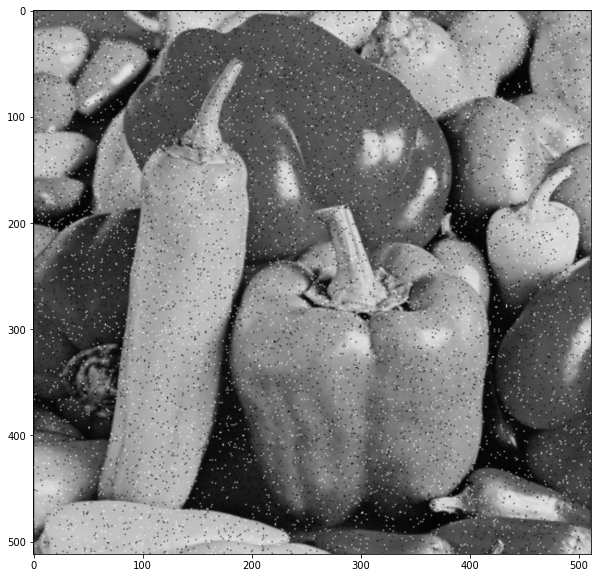

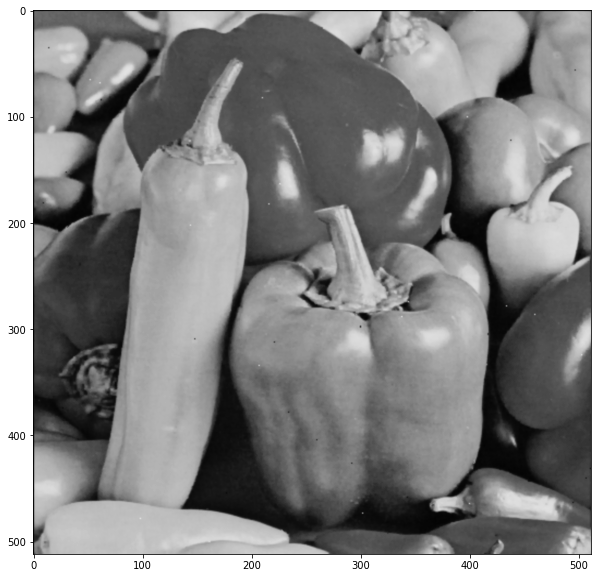

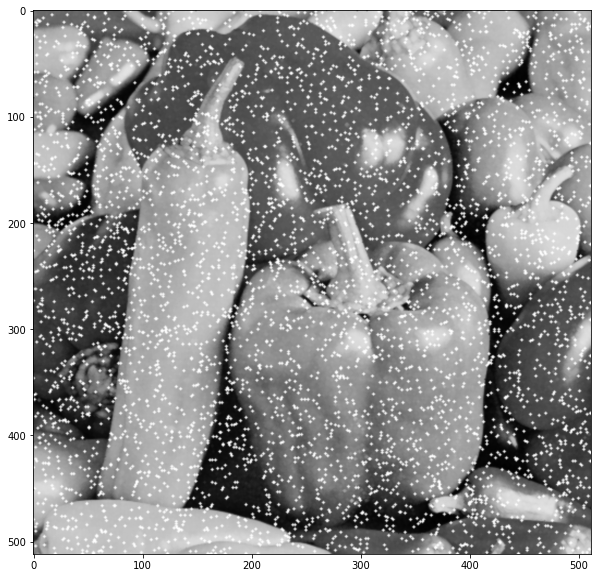

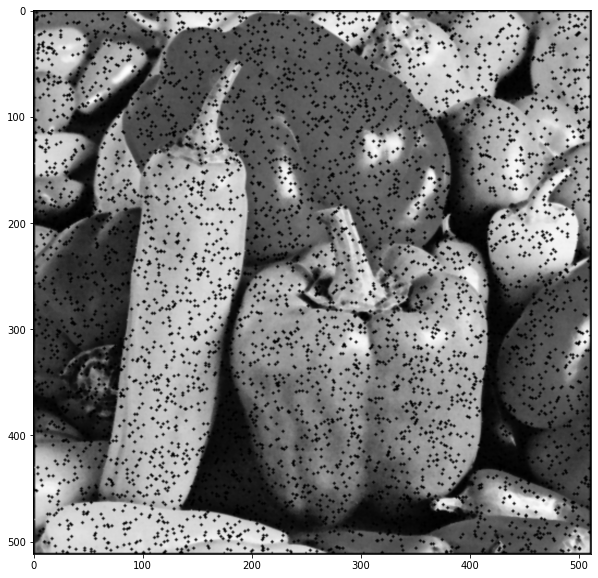

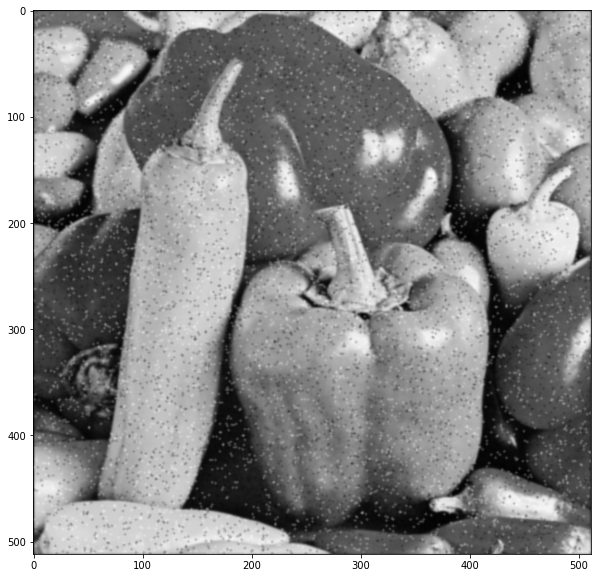

In [0]:
mask1 = np.array([[0.0,0.2,0.0],
                  [0.2,0.2,0.2],
                  [0.0,0.2,0.0]])
mask2 = np.array([[-1,0,-1],
                  [0,0,0],
                  [-1,0,-1]])

omX = 1
omY = 1
print(mask1)
%time picRes1=median_filter(pic1_gray_noised,mask1,omX,omY)
%time picRes2=max_filter(pic1_gray_noised,mask1,omX,omY)
%time picRes3=min_filter(pic1_gray_noised,mask1,omX,omY)
%time picRes4=average_filter(pic1_gray_noised,mask1,omX,omY)

im_show(pic1_gray_noised,"bicubic")
im_show(picRes1,"bicubic")
im_show(picRes2,"bicubic")
im_show(picRes3,"bicubic")
im_show(picRes4,"bicubic")

<h2>Conclutions</h2>

The best way to eliminate the Salt and Pepper noise is to use de median filter, this filter eliminate all the noise but this filter uses to much memory and the final image appears with brush on the borders, so is the best way but not a perfect way to eliminate this kind of noise.

The other 3 filters need 1 more step to eliminate the noise, the average get better but the noise still there 